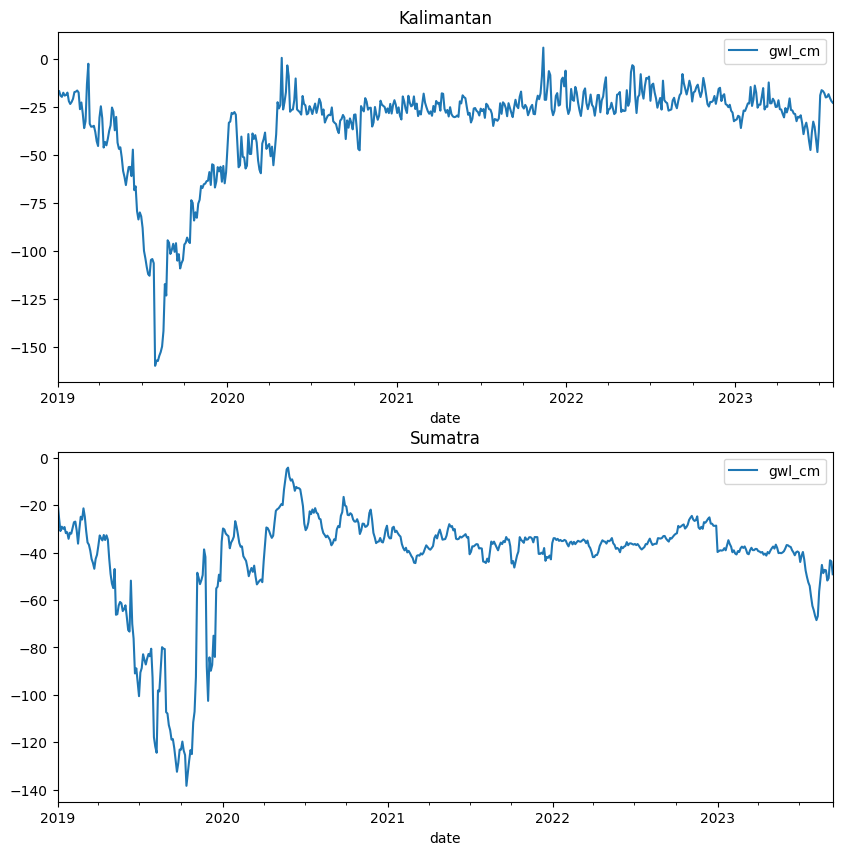

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from gee_scripts.parameters import explain_vars, response_var, west_region_ids, center_region_ids


df = pd.read_csv("data/field_data_unique_coords_and_location.csv", parse_dates=["date"])
df = df[(df.gwl_cm <= 400)&(df.date.dt.year>2018)]
df.set_index("date", inplace=True)
# Remove all that is above 400cm
# df = df[["date", "gwl_cm"]]
len(df)

kalimantan_df = df[df.region_id.isin(center_region_ids)][["gwl_cm"]]
sumatra_df = df[df.region_id.isin(west_region_ids)][["gwl_cm"]]


# data = df.sort_values(by="date")
# Set date as index

# sort by date ascending

# Aggregate data every 7 days using mean
kalimantan_resampled = kalimantan_df.resample('3D').mean()
sumatra_resampled = sumatra_df.resample('3D').mean()

# Plot the data in two subplots using seaborn

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

kalimantan_resampled.plot(ax=ax[0], title="Kalimantan")
sumatra_resampled.plot(ax=ax[1], title="Sumatra")

plt.show()


In [17]:
data = kalimantan_df[["gwl_cm"]]

# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len 

#Splitting the dataset
train_data = data[:training_data_len]
test_data = data[training_data_len:]
print(train_data.shape, test_data.shape)


(63856, 1) (15964, 1)


In [18]:
train_data

,gwl_cm
date,
2020-11-05,-37.0
2020-11-17,-39.0
2020-12-05,-39.0
2020-12-16,-35.0
2021-01-02,-34.0
...,...
2019-10-25,-115.3
2019-10-26,-103.0
2019-10-27,-86.2


In [19]:
dataset_train = train_data.gwl_cm.values 
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_train.shape


(63856, 1)

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])


[[0.63074353]
 [0.50125313]
 [0.52715121]
 [0.18629908]
 [0.68421053]]


In [37]:
dataset_test = test_data.gwl_cm.values 
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1)) 
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test) 
print(*scaled_test[:5])


[0.5581605] [0.61677187] [0.47394049] [0.53101894] [0.5852119]


In [38]:
X_train = []
y_train = []
for i in range(50, len(scaled_train)):
	X_train.append(scaled_train[i-50:i, 0])
	y_train.append(scaled_train[i, 0])
	if i <= 51:
		print(X_train)
		print(y_train)
		print()


[array([0.63074353, 0.50125313, 0.52715121, 0.18629908, 0.68421053,
       0.20050125, 0.64076859, 0.79197995, 0.67752715, 0.32247285,
       0.77276525, 0.56223893, 0.64578112, 0.73308271, 0.72347536,
       0.02422723, 0.70927318, 0.59136731, 0.43859649, 0.88840156,
       0.57560568, 0.1487051 , 0.40893901, 0.86967419, 0.68671679,
       0.39515455, 0.62322473, 0.77777778, 0.77610693, 0.35254804,
       0.75689223, 0.7786132 , 0.68504595, 0.69423559, 0.53216374,
       0.52965748, 0.85547201, 0.41687552, 0.17961571, 0.5497076 ,
       0.63074353, 0.88387636, 0.56558062, 0.88471178, 0.83792815,
       0.63241437, 0.05847953, 0.91019215, 0.77527151, 0.8053467 ])]
[0.639515455304929]

[array([0.63074353, 0.50125313, 0.52715121, 0.18629908, 0.68421053,
       0.20050125, 0.64076859, 0.79197995, 0.67752715, 0.32247285,
       0.77276525, 0.56223893, 0.64578112, 0.73308271, 0.72347536,
       0.02422723, 0.70927318, 0.59136731, 0.43859649, 0.88840156,
       0.57560568, 0.1487051 , 0.4089

In [39]:
X_test = []
y_test = []
for i in range(50, len(scaled_test)):
	X_test.append(scaled_test[i-50:i, 0])
	y_test.append(scaled_test[i, 0])


In [40]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


X_train : (4310, 50, 1) y_train : (4310, 1)


In [62]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)


X_test : (1039, 50, 1) y_test : (1039, 1)


In [70]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Setup model checkpoint
checkpoint_callback = ModelCheckpoint(
    'model_epoch_{epoch:02d}.h5',  # Saves the model with the epoch number in the filename
    save_weights_only=False,       # Can set to True if you only want to save weights
    save_best_only=False,          # Every epoch's model will be saved, not just the best
    verbose=1
)


# Setup early stopping
early_stopping_callback = EarlyStopping(
    monitor='mean_squared_error',  # Monitor validation loss (or adjust according to your setup)
    min_delta=0.001,  # Minimum change to qualify as an improvement
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # This rolls back to the best model
)

callbacks = [checkpoint_callback, early_stopping_callback]


In [41]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error


2024-06-17 11:35:02.100910: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 11:35:02.142920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 11:35:02.365369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 11:35:02.366449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 11:35:03.259092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [42]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50, 
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								decay=1e-6, 
								momentum=0.9, 
								nesterov=True), 
				loss = "mean_squared_error")

# fitting the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2, callbacks=callbacks)
regressor.summary()


2024-06-17 11:35:08.635482: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
2155/2155 [==============================] - 28s 13ms/step - loss: 0.0304
Epoch 2/20
2155/2155 [==============================] - 30s 14ms/step - loss: 0.0285
Epoch 3/20
2155/2155 [==============================] - 29s 13ms/step - loss: 0.0271
Epoch 4/20
2155/2155 [==============================] - 27s 13ms/step - loss: 0.0265
Epoch 5/20
2155/2155 [==============================] - 25s 11ms/step - loss: 0.0272
Epoch 6/20
2155/2155 [==============================] - 28s 13ms/step - loss: 0.0309
Epoch 7/20
2155/2155 [==============================] - 30s 14ms/step - loss: 0.0309
Epoch 8/20
2155/2155 [==============================] - 30s 14ms/step - loss: 0.0309
Epoch 9/20
2155/2155 [==============================] - 30s 14ms/step - loss: 0.0305
Epoch 10/20
2155/2155 [==============================] - 26s 12ms/step - loss: 0.0304
Epoch 11/20
2155/2155 [==============================] - 26s 12ms/step - loss: 0.0302
Epoch 12/20
2155/2155 [==============================] - 29s 13

In [43]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
					return_sequences = True, 
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train, 
				y_train, 
				batch_size = 1, 
				epochs = 12)
regressorLSTM.summary()


Epoch 1/12


2024-06-17 11:44:26.810726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-17 11:44:26.811632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-17 11:44:26.812211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4310/4310 [==============================] - 72s 16ms/step - loss: 0.0274 - accuracy: 2.3202e-04
Epoch 2/12
4310/4310 [==============================] - 67s 16ms/step - loss: 0.0259 - accuracy: 2.3202e-04
Epoch 3/12
4310/4310 [==============================] - 64s 15ms/step - loss: 0.0255 - accuracy: 2.3202e-04
Epoch 4/12
4310/4310 [==============================] - 65s 15ms/step - loss: 0.0254 - accuracy: 2.3202e-04
Epoch 5/12
4310/4310 [==============================] - 65s 15ms/step - loss: 0.0250 - accuracy: 2.3202e-04
Epoch 6/12
4310/4310 [==============================] - 66s 15ms/step - loss: 0.0249 - accuracy: 2.3202e-04
Epoch 7/12
4310/4310 [==============================] - 67s 16ms/step - loss: 0.0248 - accuracy: 2.3202e-04
Epoch 8/12
4310/4310 [==============================] - 66s 15ms/step - loss: 0.0248 - accuracy: 2.3202e-04
Epoch 9/12
4310/4310 [==============================] - 66s 15ms/step - loss: 0.0245 - accuracy: 4.6404e-04
Epoch 10/12
4310/4310 [================

In [44]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					input_shape=(X_train.shape[1],1),
					activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50, 
					activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
					activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, 
								decay=1e-7, 
								momentum=0.9, 
								nesterov=False),
					loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=20,batch_size=1)
regressorGRU.summary()


2024-06-17 11:57:38.086029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-17 11:57:38.086852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-17 11:57:38.087412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-06-17 11:57:38.287280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-17 11:57:38.288111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-17 11:57:38.288607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4310/4310 [==============================] - 85s 19ms/step - loss: 0.3531
Epoch 2/20
4310/4310 [==============================] - 82s 19ms/step - loss: 0.3531
Epoch 3/20
4310/4310 [==============================] - 88s 20ms/step - loss: 0.3531
Epoch 4/20
4310/4310 [==============================] - 90s 21ms/step - loss: 0.3531
Epoch 5/20
4310/4310 [==============================] - 90s 21ms/step - loss: 0.3531
Epoch 6/20
4310/4310 [==============================] - 91s 21ms/step - loss: 0.3531
Epoch 7/20
4310/4310 [==============================] - 91s 21ms/step - loss: 0.3531
Epoch 8/20
4310/4310 [==============================] - 87s 20ms/step - loss: 0.3531
Epoch 9/20
4310/4310 [==============================] - 82s 19ms/step - loss: 0.3532
Epoch 10/20
4310/4310 [==============================] - 82s 19ms/step - loss: 0.3531
Epoch 11/20
4310/4310 [==============================] - 88s 20ms/step - loss: 0.3531
Epoch 12/20
4310/4310 [==============================] - 85s 20ms/step - l

In [66]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
# y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)


33/33 [==============================] - 0s 13ms/step


In [67]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN) 
# y_LSTM_O = scaler.inverse_transform(y_LSTM) 
y_GRU_O = scaler.inverse_transform(y_GRU)


In [69]:
y_RNN_O

array([[-30.879856],
       [-30.604252],
       [-31.038374],
       ...,
       [-30.754896],
       [-30.97801 ],
       [-31.047535]], dtype=float32)

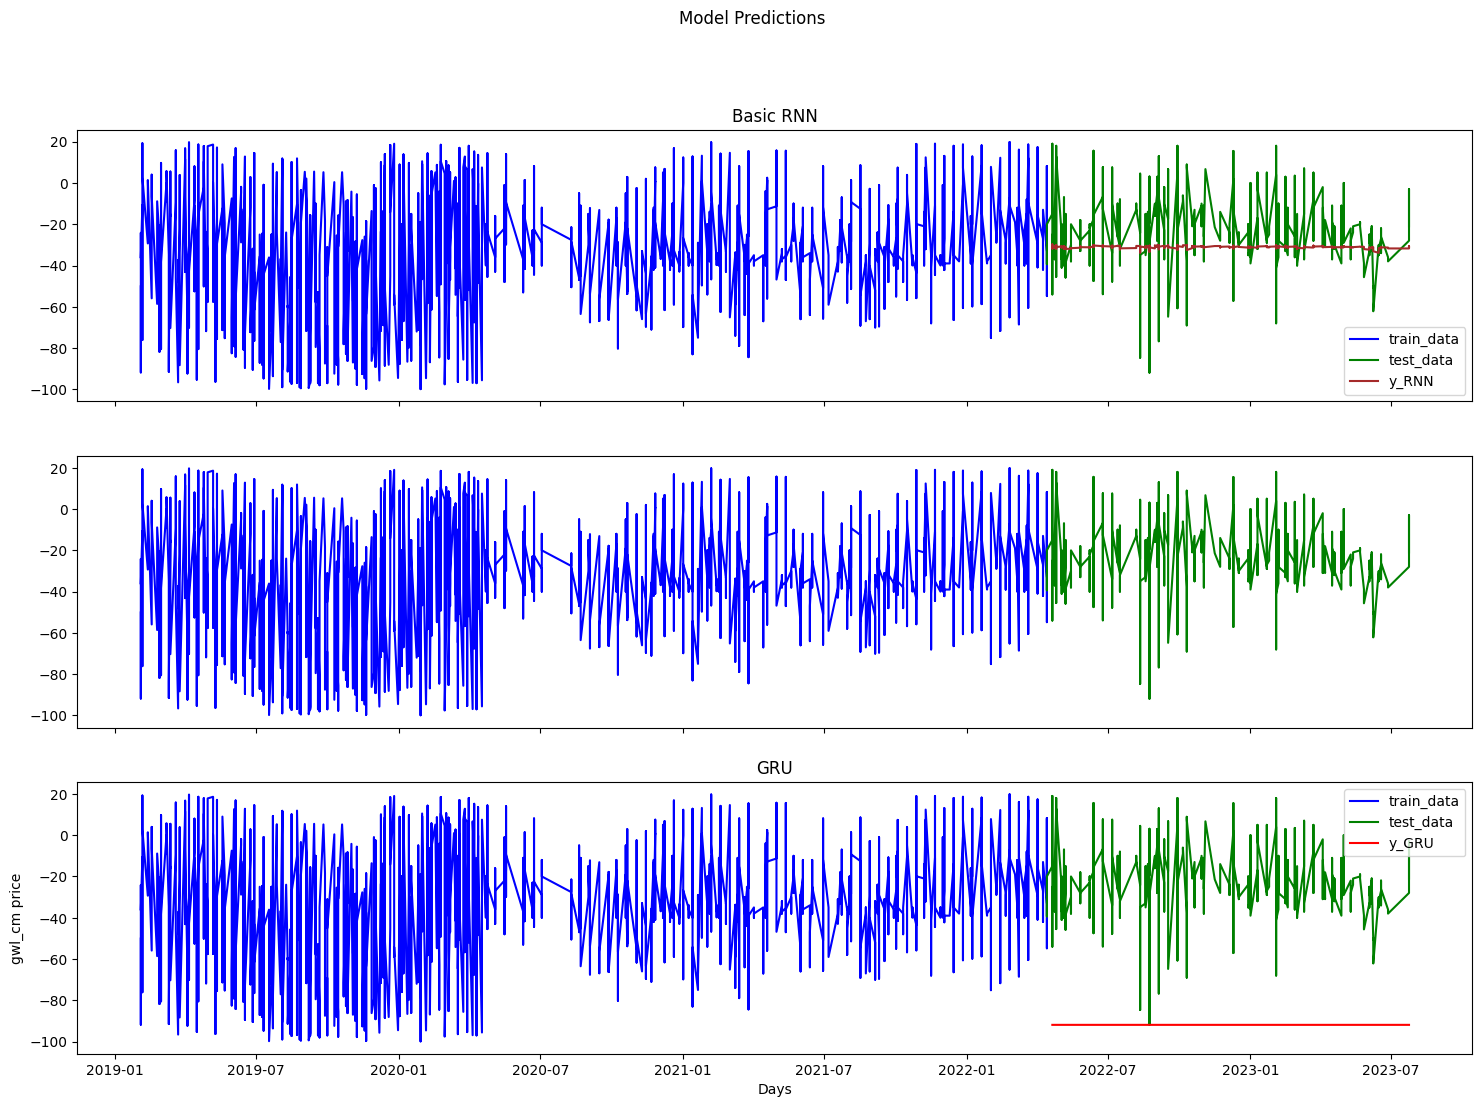

In [68]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
# axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
# axs[1].legend()
# axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.gwl_cm[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.gwl_cm, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("gwl_cm price")

plt.show()
